In [1514]:
import pandas as pd
from pandas.io.json import json_normalize

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Reading Data From Binance
🔗 Source: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

Getting M5 and M1 to DataFrame

In [1515]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df_binance_bnbusdt_5m = pd.read_json(url_binance_bnbusdt_5m)

df_binance_bnbusdt_5m.columns = [
    '5m_open_time', 
    '5m_open_price', 
    '5m_high_price', 
    '5m_low_price', 
    '5m_close_price', 
    '5m_volume', 
    '5m_close_time', 
    '5m_quote_asset_volume', 
    '5m_number_of_trades', 
    '5m_taker_buy_base_asset_volume', 
    '5m_taker_buy_quote_asset_volume', 
    '5m_unused'
]

df_binance_bnbusdt_5m.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,5m_unused
0,1665348600000,277.9,278.0,277.8,277.9,466.642,1665348899999,129680.6538,286,319.063,88669.2928,0
1,1665348900000,277.9,278.3,277.8,278.3,626.922,1665349199999,174298.2488,302,561.632,156147.9954,0
2,1665349200000,278.3,278.3,278.1,278.3,268.406,1665349499999,74674.1809,263,209.634,58326.5939,0
3,1665349500000,278.3,278.3,278.2,278.2,156.897,1665349799999,43654.4754,225,57.300,15946.5900,0
4,1665349800000,278.3,278.3,278.1,278.1,374.092,1665350099999,104057.6379,225,127.069,35356.1074,0


In [1516]:
url_binance_bnbusdt_1m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=1m"
df_binance_bnbusdt_1m = pd.read_json(url_binance_bnbusdt_1m)

df_binance_bnbusdt_1m.columns = [
    '1m_open_time', 
    '1m_open_price', 
    '1m_high_price', 
    '1m_low_price', 
    '1m_close_price', 
    '1m_volume', 
    '1m_close_time', 
    '1m_quote_asset_volume', 
    '1m_number_of_trades', 
    '1m_taker_buy_base_asset_volume', 
    '1m_taker_buy_quote_asset_volume', 
    '1m_unused'
]

df_binance_bnbusdt_1m.head()

,1m_open_time,1m_open_price,1m_high_price,1m_low_price,1m_close_price,1m_volume,1m_close_time,1m_quote_asset_volume,1m_number_of_trades,1m_taker_buy_base_asset_volume,1m_taker_buy_quote_asset_volume,1m_unused
0,1665588420000,270.9,271.0,270.9,271.0,65.408,1665588479999,17722.5858,70,35.586,9643.8060,0
1,1665588480000,271.0,271.0,270.9,271.0,30.091,1665588539999,8152.2486,45,5.967,1617.0570,0
2,1665588540000,270.9,271.0,270.9,271.0,71.056,1665588599999,19253.2398,75,41.694,11299.0740,0
3,1665588600000,270.9,271.1,270.9,271.1,97.708,1665588659999,26480.1217,99,59.862,16224.7386,0
4,1665588660000,271.1,271.1,270.9,271.0,234.751,1665588719999,63617.7234,81,12.149,3292.9888,0


In [1517]:
len(df_binance_bnbusdt_5m), len(df_binance_bnbusdt_1m)

(1000, 1000)

### Reading Rounds Data from Pancake Subgraph
🔗 Source: https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2

Method: `POST`

Query:

{ query: "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) {
    id
    epoch
    position
    failed
    startAt
    startBlock
    startHash
    lockAt
    lockBlock
    lockHash
    lockPrice
    lockRoundId
    closeAt
    closeBlock
    closeHash
    closePrice
    closeRoundId
    totalBets
    totalAmount
    bullBets
    bullAmount
    bearBets
    bearAmount
    }
}", }

In [1518]:
pancake_subgraph_url = 'https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2'
pancake_rounds_query = '{"query": "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) { id epoch position failed startAt startBlock startHash lockAt lockBlock lockHash lockPrice lockRoundId closeAt closeBlock closeHash closePrice closeRoundId totalBets totalAmount bullBets bullAmount bearBets bearAmount } }"}'

In [1519]:
import requests
req_pancake_rounds = requests.post(url=pancake_subgraph_url, data=pancake_rounds_query)

In [1520]:
req_pancake_rounds

<Response [200]>

In [1521]:
json_pancake_rounds = req_pancake_rounds.json()

In [1522]:
len(json_pancake_rounds["data"]["rounds"])

1000

In [1523]:
df_pancake_rounds = pd.DataFrame.from_dict(json_pancake_rounds["data"]["rounds"])

In [1524]:
df_pancake_rounds.head()

,id,epoch,position,failed,startAt,startBlock,startHash,lockAt,lockBlock,lockHash,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,111634,111634,Bear,False,1665647546,22134409,0xd5eef6804afe9ea10f005ffd154e6ab7386ed840170c...,1665647855,22134512,0x3357466c20bfd841b7060c7ed2900a579c07ce01c2b3...,...,22134615,0xede020a8b54c0f30de788f7c5cb44547cd6f91eba76f...,264.19311761,18446744073711495055,39,3.675439436590276765,24,2.730022278149481354,15,0.945417158440795411
1,111631,111631,Bull,False,1665645812,22133847,0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...,1665646120,22133943,0x29d0c5bf6eed0e69a0b5184aa97764ef87b8ff432cb8...,...,22134039,0x67591831d3a1f0a4fb680d75126ba280490819e4dd9f...,265.27,18446744073711494973,103,18.002820064938191092,60,12.387859529427860303,43,5.614960535510330789
2,111630,111630,Bear,False,1665645501,22133746,0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...,1665645812,22133847,0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...,...,22133943,0x29d0c5bf6eed0e69a0b5184aa97764ef87b8ff432cb8...,265.00595197,18446744073711494961,68,10.236740735545830335,40,6.061883179486926414,28,4.174857556058903921
3,111629,111629,Bull,False,1665645195,22133644,0x2feef7dc863618f2495f0d3ee8d624f4540d965c5678...,1665645501,22133746,0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...,...,22133847,0x49e21af684302d4c4d9e76ca5d80e374ef64e9b118a7...,265.4239489,18446744073711494947,99,26.411113859872661446,68,21.349118173973520529,31,5.061995685899140917
4,111628,111628,Bull,False,1665644886,22133541,0xb3b9891f73be388774273b32d803e5ad22b71f7c57db...,1665645195,22133644,0x2feef7dc863618f2495f0d3ee8d624f4540d965c5678...,...,22133746,0xc37e4ccc8ffbe4af92808ab4df787a5bb4c67d25d98c...,264.91,18446744073711494931,95,24.611658672776836948,44,9.935110972540265592,51,14.676547700236571356


In [1525]:
# Create a key-column to join DataFrames
df_binance_bnbusdt_5m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_5m["5m_close_time"], unit='ms')
df_binance_bnbusdt_1m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_1m["1m_close_time"], unit='ms')
df_pancake_rounds["timestamp_key"] = pd.to_datetime(df_pancake_rounds["closeAt"], unit='s')

# Sort by join key
df_binance_bnbusdt_5m.sort_values('timestamp_key', inplace=True)
df_binance_bnbusdt_1m.sort_values('timestamp_key', inplace=True)
df_pancake_rounds.sort_values('timestamp_key', inplace=True)

In [1526]:
# Join Dataframes
df_joined = pd.merge_asof(df_binance_bnbusdt_5m, df_pancake_rounds, on='timestamp_key',direction = 'nearest', tolerance=pd.Timedelta("5 min"))

# Remove Empty epoch column records
df_joined.dropna(subset=['epoch'], inplace=True)

df_joined.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665348600000,277.9,278.0,277.8,277.9,466.642,1665348899999,129680.6538,286,319.063,...,22036577,0x3860c5df457e0731aa2fd1eb52d83b7bafd72f2d1217...,277.9779039,18446744073711481107,85,15.311851917591523339,48,4.564011726009393004,37,10.747840191582130335
1,1665348900000,277.9,278.3,277.8,278.3,626.922,1665349199999,174298.2488,302,561.632,...,22036680,0x1fdf920ea2621f5fcad796511a42d6af2de07b0501ba...,278.24726038,18446744073711481121,81,19.30762102666727336,44,12.885763801752253277,37,6.421857224915020083
2,1665349200000,278.3,278.3,278.1,278.3,268.406,1665349499999,74674.1809,263,209.634,...,22036783,0xe41e87793ce3b6a1d2d9865f8ee83111fb6614cfe7d6...,278.2927179,18446744073711481137,71,19.126926103779853499,33,9.848900922913279001,38,9.278025180866574498
3,1665349500000,278.3,278.3,278.2,278.2,156.897,1665349799999,43654.4754,225,57.300,...,22036886,0xb7b387113144606d38b33cb775898af780a09f290261...,278.25,18446744073711481149,75,10.345646480939715064,41,5.569954947670802659,34,4.775691533268912405
4,1665349800000,278.3,278.3,278.1,278.1,374.092,1665350099999,104057.6379,225,127.069,...,22036989,0xf57afaab3c804f245ddcde65bccc9dc12f4de6ac289e...,278.13,18446744073711481163,62,8.088740454326477237,29,3.719416931566822368,33,4.369323522759654869


In [1527]:
df_distinct = df_joined.drop_duplicates(['epoch'], keep='last')
df_distinct.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665348600000,277.9,278.0,277.8,277.9,466.642,1665348899999,129680.6538,286,319.063,...,22036577,0x3860c5df457e0731aa2fd1eb52d83b7bafd72f2d1217...,277.9779039,18446744073711481107,85,15.311851917591523339,48,4.564011726009393004,37,10.747840191582130335
1,1665348900000,277.9,278.3,277.8,278.3,626.922,1665349199999,174298.2488,302,561.632,...,22036680,0x1fdf920ea2621f5fcad796511a42d6af2de07b0501ba...,278.24726038,18446744073711481121,81,19.30762102666727336,44,12.885763801752253277,37,6.421857224915020083
2,1665349200000,278.3,278.3,278.1,278.3,268.406,1665349499999,74674.1809,263,209.634,...,22036783,0xe41e87793ce3b6a1d2d9865f8ee83111fb6614cfe7d6...,278.2927179,18446744073711481137,71,19.126926103779853499,33,9.848900922913279001,38,9.278025180866574498
3,1665349500000,278.3,278.3,278.2,278.2,156.897,1665349799999,43654.4754,225,57.300,...,22036886,0xb7b387113144606d38b33cb775898af780a09f290261...,278.25,18446744073711481149,75,10.345646480939715064,41,5.569954947670802659,34,4.775691533268912405
4,1665349800000,278.3,278.3,278.1,278.1,374.092,1665350099999,104057.6379,225,127.069,...,22036989,0xf57afaab3c804f245ddcde65bccc9dc12f4de6ac289e...,278.13,18446744073711481163,62,8.088740454326477237,29,3.719416931566822368,33,4.369323522759654869


In [1528]:
# Exporting Data Frame
df_distinct.to_csv("dataset-to-predict.csv", index=False)

In [1529]:
# Remove unused columns
df_predict = df_distinct.drop([
    '5m_open_time', 
    '5m_close_time', 
    '5m_unused', 
    'timestamp_key', 
    'id', 
    'epoch', 
    'failed', 
    'startAt', 
    'startBlock', 
    'startHash', 
    'lockAt', 
    'lockBlock', 
    'lockHash', 
    'lockRoundId', 
    'closeAt', 
    'closeBlock', 
    'closeHash', 
    'closeRoundId'], axis=1)


df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,277.9,278.0,277.8,277.9,466.642,129680.6538,286,319.063,88669.2928,Bear,278.04700638,277.9779039,85,15.311851917591523339,48,4.564011726009393004,37,10.747840191582130335
1,277.9,278.3,277.8,278.3,626.922,174298.2488,302,561.632,156147.9954,Bull,277.9779039,278.24726038,81,19.30762102666727336,44,12.885763801752253277,37,6.421857224915020083
2,278.3,278.3,278.1,278.3,268.406,74674.1809,263,209.634,58326.5939,Bull,278.24726038,278.2927179,71,19.126926103779853499,33,9.848900922913279001,38,9.278025180866574498
3,278.3,278.3,278.2,278.2,156.897,43654.4754,225,57.300,15946.5900,Bear,278.2927179,278.25,75,10.345646480939715064,41,5.569954947670802659,34,4.775691533268912405
4,278.3,278.3,278.1,278.1,374.092,104057.6379,225,127.069,35356.1074,Bear,278.25,278.13,62,8.088740454326477237,29,3.719416931566822368,33,4.369323522759654869


In [1530]:
df_predict["lockPrice"] = pd.to_numeric(df_predict["lockPrice"])
df_predict["closePrice"] = pd.to_numeric(df_predict["closePrice"])
df_predict["totalBets"] = pd.to_numeric(df_predict["totalBets"])
df_predict["totalAmount"] = pd.to_numeric(df_predict["totalAmount"])
df_predict["bullBets"] = pd.to_numeric(df_predict["bullBets"])
df_predict["bullAmount"] = pd.to_numeric(df_predict["bullAmount"])
df_predict["bearBets"] = pd.to_numeric(df_predict["bearBets"])
df_predict["bearAmount"] = pd.to_numeric(df_predict["bearAmount"])
df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,277.9,278.0,277.8,277.9,466.642,129680.6538,286,319.063,88669.2928,Bear,278.047006,277.977904,85,15.311852,48,4.564012,37,10.747840
1,277.9,278.3,277.8,278.3,626.922,174298.2488,302,561.632,156147.9954,Bull,277.977904,278.247260,81,19.307621,44,12.885764,37,6.421857
2,278.3,278.3,278.1,278.3,268.406,74674.1809,263,209.634,58326.5939,Bull,278.247260,278.292718,71,19.126926,33,9.848901,38,9.278025
3,278.3,278.3,278.2,278.2,156.897,43654.4754,225,57.300,15946.5900,Bear,278.292718,278.250000,75,10.345646,41,5.569955,34,4.775692
4,278.3,278.3,278.1,278.1,374.092,104057.6379,225,127.069,35356.1074,Bear,278.250000,278.130000,62,8.088740,29,3.719417,33,4.369324


In [1531]:
# Change position column to 0 or 1 column
df_predict["position_code"] = pd.Categorical(df_predict.position).codes
df_predict.drop("position", axis=1, inplace=True)

In [1532]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["5m_open_price", "5m_high_price", "5m_low_price", "5m_close_price", "5m_volume", "5m_quote_asset_volume", "5m_number_of_trades", "5m_taker_buy_base_asset_volume", "5m_taker_buy_quote_asset_volume", "lockPrice", "closePrice", "totalBets", "totalAmount", "bullBets", "bullAmount", "bearBets", "bearAmount"]), # turn all values in these columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), [])
)

In [1533]:
# Create X & y values

# The X (independent variables) will be every column of DataFrame except charges
X_read = df_predict.drop("position_code", axis=1)

# The y (dependent or label) is charges column
y_read = df_predict["position_code"]

In [1534]:
# The position Bear or Bull is for the next, so we'll shift removing first row of y and last row for X

# Drop first row of y
y = y_read.drop(index=y_read.index[0], axis=0)

# Drop last row of X
X = X_read.drop(index=X_read.index[-1], axis=0)

In [1535]:
# Split dataset in random set to train using sklearn
# Separate 20% (0.2) for test and 80% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1536]:
len(X_train), len(X_test), len(y_train), len(y_test)

(669, 168, 669, 168)

In [1537]:
X_train.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
374,270.1,270.1,269.8,269.8,567.551,153188.8680,404,190.393,51391.6310,270.008823,269.850000,57,6.969276,17,2.133296,40,4.835981
258,274.8,274.8,274.1,274.3,753.221,206699.1479,449,322.003,88366.1886,274.510000,274.570335,93,23.182227,51,16.725721,42,6.456506
479,272.9,273.1,272.7,273.0,443.525,121055.6322,485,150.098,40969.8375,273.034120,272.904459,80,23.517551,41,12.211543,39,11.306008
357,269.9,270.4,269.9,270.3,987.367,266766.3996,558,575.782,155566.4148,269.730000,270.012500,74,8.619362,43,5.234679,31,3.384683
603,271.1,271.5,271.1,271.3,1115.872,302780.7560,577,519.857,141066.4860,270.965065,271.243407,30,1.819646,18,1.236455,12,0.583192


In [1538]:
# Fit the column transformer to our training data
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['5m_open_price', '5m_high_price',
                                  '5m_low_price', '5m_close_price', '5m_volume',
                                  '5m_quote_asset_volume',
                                  '5m_number_of_trades',
                                  '5m_taker_buy_base_asset_volume',
                                  '5m_taker_buy_quote_asset_volume',
                                  'lockPrice', 'closePrice', 'totalBets',
                                  'totalAmount', 'bullBets', 'bullAmount',
                                  'bearBets', 'bearAmount']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'), [])])

In [1539]:
# Transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [1540]:
# What does our data look like now?
X_train.loc[0], X_train_normal[0]

(5m_open_price                         277.900000
 5m_high_price                         278.000000
 5m_low_price                          277.800000
 5m_close_price                        277.900000
 5m_volume                             466.642000
 5m_quote_asset_volume              129680.653800
 5m_number_of_trades                   286.000000
 5m_taker_buy_base_asset_volume        319.063000
 5m_taker_buy_quote_asset_volume     88669.292800
 lockPrice                             278.047006
 closePrice                            277.977904
 totalBets                              85.000000
 totalAmount                            15.311852
 bullBets                               48.000000
 bullAmount                              4.564012
 bearBets                               37.000000
 bearAmount                             10.747840
 Name: 0, dtype: float64,
 array([0.35036496, 0.32592593, 0.36619718, 0.35416667, 0.04107467,
        0.04021524, 0.0470094 , 0.03936625, 0.03861433, 

In [1541]:
# Test area

In [1542]:
# Discover top result

# tf.random.set_seed(42)

# top_result = 100 # high number
# top_result_layers = [1, 1, 1, 1, 1]
# top_model = None

# loop_upper_bound = 2101

# rand_neuron_max = 100;

# for ix in range(1, loop_upper_bound):
    
#     n0 = np.random.randint(rand_neuron_max, size=1)[0]
#     n1 = np.random.randint(rand_neuron_max, size=1)[0]
#     n2 = np.random.randint(rand_neuron_max, size=1)[0]
#     n3 = np.random.randint(rand_neuron_max, size=1)[0]
#     n4 = np.random.randint(rand_neuron_max, size=1)[0]
    
#     # 1. Create the model (based on insurance_model_2)
#     model_a = tf.keras.Sequential([
#         tf.keras.layers.Dense(n0, name="hidden_layer_1"),
#         tf.keras.layers.Dense(n1, name="hidden_layer_2"),
#         # tf.keras.layers.Dense(n2, name="hidden_layer_3"),
#         # tf.keras.layers.Dense(n3, name="hidden_layer_4"),
#         # tf.keras.layers.Dense(n4, name="hidden_layer_5"),
#         tf.keras.layers.Dense(1, name="output_layer")
#     ], name="model_a")

#     # 2. Compile the model
#     model_a.compile(loss=tf.keras.losses.mse,
#                               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                               metrics=["mae"])

#     # 3. Fit the model
#     history_model_a = model_a.fit(X_train_normal, y_train, epochs=60, verbose=0)

#     # Evaluate our insurance model trained on normalized data

#     evaluate_result = model_a.evaluate(X_test_normal, y_test)
#     if evaluate_result[0] < top_result:
#         top_result = evaluate_result[0]
#         top_result_layers = [n0, n1, n2, n3, n4]
#         top_model = model_a

#         print("result %f" % (top_result))
#         print(top_result_layers)

        
# model_a = top_model
# print("===== Top Final Result %f =====" % (top_result))
# print(top_result_layers)

6/6 [==============================] - 0s 858us/step - loss: 0.2399 - mae: 0.4736


Text(0.5, 0, 'epochs')

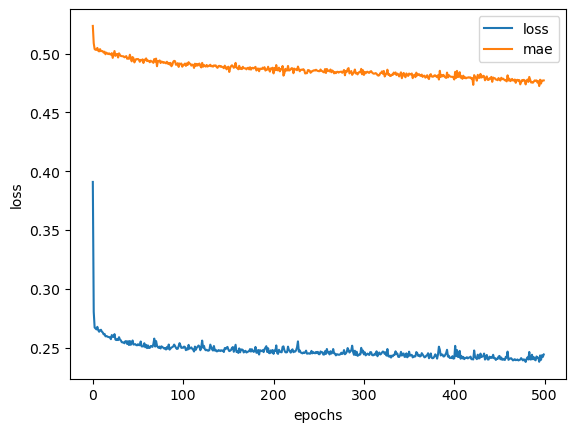

In [1543]:
tf.random.set_seed(42)

# 1. Create the model (based on insurance_model_2)
model_a = tf.keras.Sequential([
    tf.keras.layers.Dense(100, name="hidden_layer_1"),
    tf.keras.layers.Dense(100, name="hidden_layer_2"),
    tf.keras.layers.Dense(50, name="hidden_layer_3"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model_a")

# 2. Compile the model
model_a.compile(loss=tf.keras.losses.mse,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          metrics=["mae"])

# 3. Fit the model
history_model_a = model_a.fit(X_train_normal, y_train, epochs=500, verbose=0)

# Evaluate our insurance model trained on normalized data

evaluate_result = model_a.evaluate(X_test_normal, y_test)

# Plot history (also known as a loss curve or training curve)
pd.DataFrame(history_model_a.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [1544]:
# Predict the first n results of train
predict_sample = X_train.head(10)
record_to_predict = ct.transform(predict_sample)
predict_result = model_a.predict(record_to_predict)

predict_sample

1/1 [==============================] - 0s 34ms/step


,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
374,270.1,270.1,269.8,269.8,567.551,153188.8680,404,190.393,51391.6310,270.008823,269.850000,57,6.969276,17,2.133296,40,4.835981
258,274.8,274.8,274.1,274.3,753.221,206699.1479,449,322.003,88366.1886,274.510000,274.570335,93,23.182227,51,16.725721,42,6.456506
479,272.9,273.1,272.7,273.0,443.525,121055.6322,485,150.098,40969.8375,273.034120,272.904459,80,23.517551,41,12.211543,39,11.306008
357,269.9,270.4,269.9,270.3,987.367,266766.3996,558,575.782,155566.4148,269.730000,270.012500,74,8.619362,43,5.234679,31,3.384683
603,271.1,271.5,271.1,271.3,1115.872,302780.7560,577,519.857,141066.4860,270.965065,271.243407,30,1.819646,18,1.236455,12,0.583192
786,270.4,270.4,270.0,270.3,757.738,204707.4189,560,435.709,117716.5693,270.190659,270.250524,78,12.836824,46,8.139335,32,4.697490
82,277.8,277.9,277.8,277.9,232.530,64603.3437,175,65.097,18090.4563,277.900077,277.817452,78,10.391495,43,5.956653,35,4.434842
152,274.4,274.4,274.1,274.1,948.310,260036.6552,542,222.061,60908.6866,274.285306,274.032185,93,26.780360,56,17.369189,37,9.411171
379,269.9,270.0,269.7,269.7,159.869,43137.5337,278,57.401,15490.1808,269.884752,269.731638,71,7.519670,46,4.916045,25,2.603625
654,271.9,272.0,271.6,271.7,394.497,107220.1704,302,69.632,18923.7579,271.950000,271.832514,55,12.376842,37,11.112244,18,1.264598


In [1545]:
y_train.head(10), predict_result

(375    1
 259    0
 480    0
 358    1
 604    0
 787    1
 83     1
 154    1
 380    0
 655    0
 Name: position_code, dtype: int8,
 array([[0.45377436],
        [0.43729213],
        [0.5176709 ],
        [0.67390627],
        [0.6053183 ],
        [0.53908515],
        [0.47820768],
        [0.42061183],
        [0.42159712],
        [0.4543496 ]], dtype=float32))

In [1546]:
np.squeeze(np.rint(predict_result)) == y_train.head(10)

375    False
259     True
480    False
358     True
604    False
787     True
83     False
154    False
380     True
655     True
Name: position_code, dtype: bool

### Best result
* 100 (relu) -> 10 (relu) -> 1 (relu) -> 1 (output linear)
* Adam(learning_rate: 0.001)
* loss mse
* Epochs: 200

0.2500512897968292

In [1547]:
model_a.summary()

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1800      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 50)                5050      
                                                                 
 output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 17,001
Trainable params: 17,001
Non-trainable params: 0
_________________________________________________________________


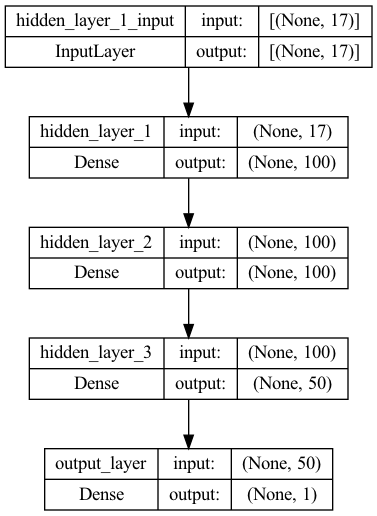

In [1548]:
plot_model(model_a, show_shapes=True)

In [1549]:
# Save model using the SavedModel format
!mkdir -p saved_model
model_a.save('saved_model/prediction_linear_regression_model_a')

INFO:tensorflow:Assets written to: saved_model/prediction_linear_regression_model_a/assets


In [1550]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model_a.save('hdf5/prediction_linear_regression_model_a.h5')